In [34]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error

from pandas.tseries.offsets import MonthEnd

In [35]:
# Cargar datos desde un archivo Excel
file_path = './Historical Product Demand.xlsx'  
data = pd.read_excel(file_path)

Análisis Exploratorio

In [36]:
data.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0002,Whse_S,Category_005,2012-03-01,50000
1,Product_0002,Whse_S,Category_005,2012-05-02,50000
2,Product_0002,Whse_S,Category_005,2012-07-03,30000
3,Product_0002,Whse_S,Category_005,2012-09-05,10000
4,Product_0002,Whse_S,Category_005,2012-11-08,30000


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1715 entries, 0 to 1714
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Product_Code      1715 non-null   object        
 1   Warehouse         1715 non-null   object        
 2   Product_Category  1715 non-null   object        
 3   Date              1715 non-null   datetime64[ns]
 4   Order_Demand      1715 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 67.1+ KB


In [38]:
print(data.describe())

                                Date   Order_Demand
count                           1715    1715.000000
mean   2014-07-15 07:08:13.294460416    5510.262391
min              2011-12-16 00:00:00  -40000.000000
25%              2013-05-29 00:00:00     200.000000
50%              2014-08-08 00:00:00     400.000000
75%              2015-08-06 00:00:00    2000.000000
max              2016-12-29 00:00:00  500000.000000
std                              NaN   19901.842549


In [39]:
# Obtener los valores únicos de la columna 'Product_Code'
unique_product_codes = data['Product_Code'].unique()

# Imprimir los valores únicos
print(unique_product_codes)

['Product_0002' 'Product_0001' 'Product_0003' 'Product_0004']


In [40]:
# Obtener los valores únicos de la columna 'Product_Code'
unique_product_codes = data['Warehouse'].unique()

# Imprimir los valores únicos
print(unique_product_codes)

['Whse_S' 'Whse_J' 'Whse_C' 'Whse_A']


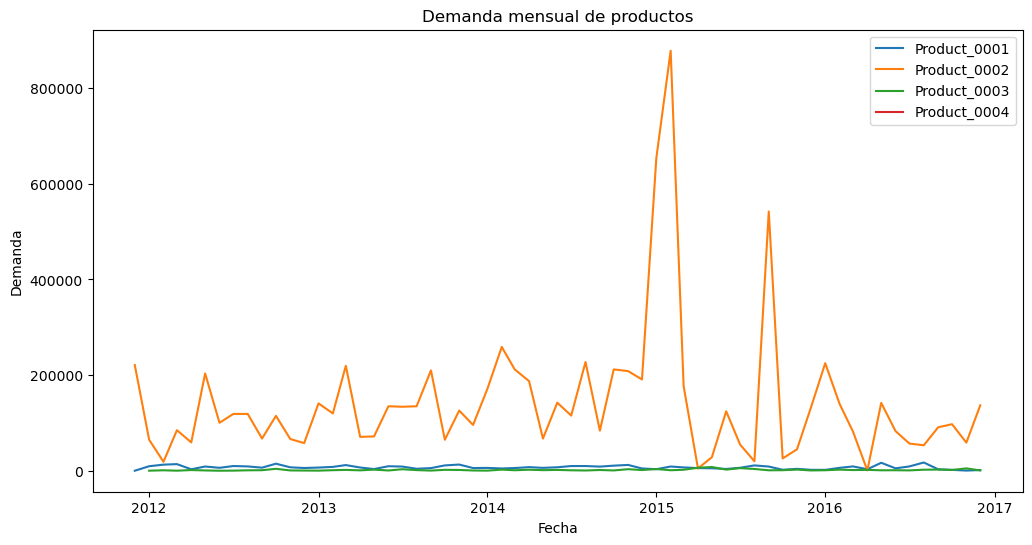

In [41]:
# Filtrar los datos para cada producto

data_0001 = data[data['Product_Code'] == 'Product_0001']
data_0002 = data[data['Product_Code'] == 'Product_0002']
data_0003 = data[data['Product_Code'] == 'Product_0003']
data_0004 = data[data['Product_Code'] == 'Product_0004']

# Convertir la columna 'Date' a formato de fecha

data_0001.loc[:,'Date'] = pd.to_datetime(data_0001['Date'])
data_0002.loc[:,'Date'] = pd.to_datetime(data_0002['Date'])
data_0003.loc[:,'Date'] = pd.to_datetime(data_0003['Date'])
data_0004.loc[:,'Date'] = pd.to_datetime(data_0004['Date'])

# Agrupar los datos por mes y sumar la demanda

monthly_demand_0001 = data_0001.groupby(data_0001['Date'].dt.to_period('M')).sum(numeric_only=True)
monthly_demand_0002 = data_0002.groupby(data_0002['Date'].dt.to_period('M')).sum(numeric_only=True)
monthly_demand_0003 = data_0003.groupby(data_0003['Date'].dt.to_period('M')).sum(numeric_only=True)
monthly_demand_0004 = data_0004.groupby(data_0002['Date'].dt.to_period('M')).sum(numeric_only=True)

# Graficar las series de tiempo de la demanda

plt.figure(figsize=(12, 6))
plt.plot(monthly_demand_0001.index.to_timestamp(), monthly_demand_0001['Order_Demand'], label='Product_0001')
plt.plot(monthly_demand_0002.index.to_timestamp(), monthly_demand_0002['Order_Demand'], label='Product_0002')
plt.plot(monthly_demand_0003.index.to_timestamp(), monthly_demand_0003['Order_Demand'], label='Product_0003')
plt.plot(monthly_demand_0004.index.to_timestamp(), monthly_demand_0004['Order_Demand'], label='Product_0004')

plt.title('Demanda mensual de productos')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()

In [42]:
# Elegir producto a analizar
producto = 'Product_0001'

In [43]:
# Filtrar los datos para Producto
data_prod = data[data['Product_Code'] == producto]

In [44]:
# Convertir la columna 'Date' a formato de fecha
data_prod['Date'] = pd.to_datetime(data_prod['Date'])

C:\Users\roage\AppData\Local\Temp\ipykernel_39712\2941081994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prod['Date'] = pd.to_datetime(data_prod['Date'])


In [45]:
# Agrupar los datos por mes y sumar la demanda
monthly_demand = data_prod.groupby(data_prod['Date'].dt.to_period('M')).sum(numeric_only=True)

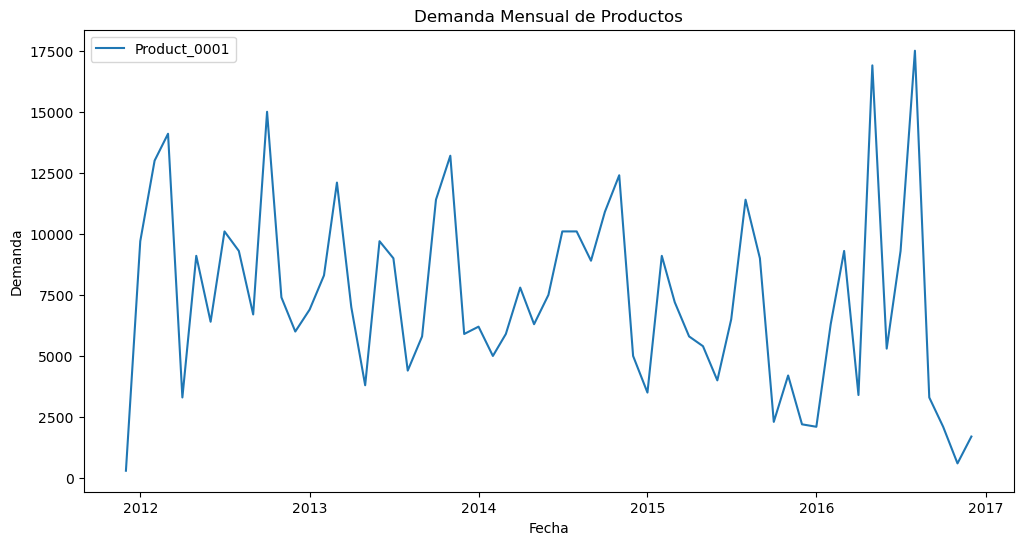

In [46]:
# Graficar las series de tiempo de la demanda
plt.figure(figsize=(12, 6))
plt.plot(monthly_demand.index.to_timestamp(), monthly_demand['Order_Demand'], label=producto)
plt.title('Demanda Mensual de Productos')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()

In [47]:
# Dividir los datos en entrenamiento y prueba
train = monthly_demand.iloc[:-12]
test = monthly_demand.iloc[-12:]

In [48]:
# Modelo ARIMA
model_arima = ARIMA(train, order=(5, 1, 0))
model_arima_fit = model_arima.fit()
arima_forecast = model_arima_fit.forecast(steps=12)
mse_arima = mean_squared_error(test, arima_forecast)
mae_arima = mean_absolute_error(test, arima_forecast)

In [49]:
# Modelo SARIMA
model_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarima_fit = model_sarima.fit()
sarima_forecast = model_sarima_fit.forecast(steps=12)
mse_sarima = mean_squared_error(test, sarima_forecast)
mae_sarima = mean_absolute_error(test, sarima_forecast)

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [50]:
print(f"ARIMA MSE: {mse_arima}, MAE: {mae_arima}")
print(f"SARIMA MSE: {mse_sarima}, MAE: {mae_sarima}")

ARIMA MSE: 36493291.81234858, MAE: 4358.452502587151
SARIMA MSE: 27913627.494573142, MAE: 3649.628542168564


In [51]:
# Modelo ARIMA - con manejo de excepciones
try:
    model_arima = ARIMA(train, order=(1, 1, 1))
    model_arima_fit = model_arima.fit()
    arima_forecast = model_arima_fit.forecast(steps=12)
    mse_arima = mean_squared_error(test, arima_forecast)
    mae_arima = mean_absolute_error(test, arima_forecast)
    print(f"ARIMA MSE: {mse_arima}, MAE: {mae_arima}")
except Exception as e:
    print(f"Error en el modelo ARIMA: {e}")


ARIMA MSE: 29997762.884906206, MAE: 4682.117324083149


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [52]:
# Modelo SARIMA - con manejo de excepciones
if len(train) >= 24:  # Verificar si hay suficientes datos para un modelo estacional
    try:
        model_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        model_sarima_fit = model_sarima.fit()
        sarima_forecast = model_sarima_fit.forecast(steps=12)
        mse_sarima = mean_squared_error(test, sarima_forecast)
        mae_sarima = mean_absolute_error(test, sarima_forecast)
        print(f"SARIMA MSE: {mse_sarima}, MAE: {mae_sarima}")
    except Exception as e:
        print(f"Error en el modelo SARIMA: {e}")
else:
    print("No hay suficientes datos para el modelo SARIMA.")

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA MSE: 27913627.494573142, MAE: 3649.628542168564


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [53]:
# Realizar pronósticos
forecast_next_month = model_sarima_fit.forecast(steps=1)
forecast_next_3_months = model_sarima_fit.forecast(steps=3)
forecast_next_6_months = model_sarima_fit.forecast(steps=6)

In [54]:
# Fechas de los pronósticos
last_date = monthly_demand.index[-1]
forecast_dates = [last_date + MonthEnd(n) for n in range(1, 7)]

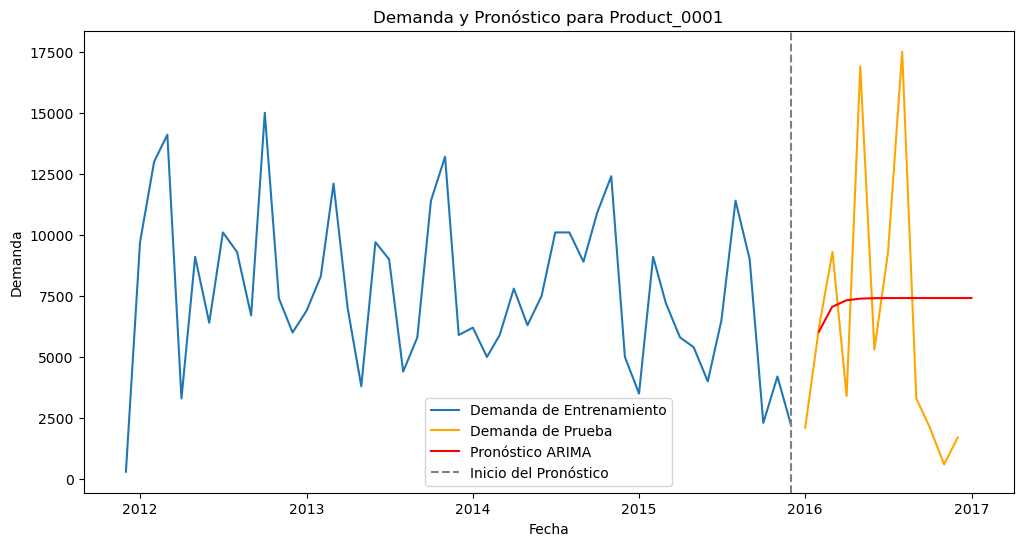

In [55]:
import matplotlib.pyplot as plt

# Convertir el índice de 'train' y 'test' a formato de fecha para el gráfico
train.index = train.index.to_timestamp()
test.index = test.index.to_timestamp()

# Crear fechas para los pronósticos
last_train_date = train.index[-1]
forecast_dates = pd.date_range(start=last_train_date, periods=len(arima_forecast) + 1, freq='M')[1:]

# Graficar la serie temporal y los pronósticos
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Order_Demand'], label='Demanda de Entrenamiento')
plt.plot(test.index, test['Order_Demand'], label='Demanda de Prueba', color='orange')
plt.plot(forecast_dates, arima_forecast, label='Pronóstico ARIMA', color='red')
plt.axvline(x=last_train_date, color='gray', linestyle='--', label='Inicio del Pronóstico')
plt.title('Demanda y Pronóstico para ' + producto)
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()



In [56]:
print(forecast_next_6_months)

2016-01    3468.693839
2016-02    6473.327367
2016-03    6501.014068
2016-04    3995.602249
2016-05    3982.341003
2016-06    3974.645084
Freq: M, Name: predicted_mean, dtype: float64
